In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 8 (Query Translation - Step-Back Prompting)"

# Query translation

![](images/query-translation-01.png)

![](images/query-translation-02.png)

# Part 8: Query Translation - Step Back

**Questions**
- What happens to the pressure, P, of an ideal gas if the temperature is increased by a factor of 2 and the volume is increased by a factor of 8?
- Estella Leopold went to which school between Aug 1954 and Nov 1954?

![](images/08-step-back.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9654a743ed', 'id': 'chatcmpl-BKNPKjUKcAiENQFSlvU3ziBULJiwT', 'finish_reason': 'stop', 'logprobs': None}, id='run-0668b473-3240-4cb3-8726-b72968f2efd9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [14]:
from typing import Annotated, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

In [15]:
step_back_prompt_template = "You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:"

examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]

example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

step_back_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", step_back_prompt_template),
        few_shot_prompt,
        ("human", "{question}")
    ]
)

In [16]:
final_answer_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

{context}
{step_back_context}

Original Question: {question}
Answer:"""
print(final_answer_prompt_template)

You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

{context}
{step_back_context}

Original Question: {question}
Answer:


In [17]:
query = "What is task decomposition for LLM agents?"

In [18]:
class State(TypedDict):
    question: str
    context: list[Document]
    step_back_question: str
    step_back_context: list[Document]
    answer: str

In [19]:
def retrieve_docs(state: State):
    question = state["question"]
    retrieved_docs = vectorstore.similarity_search(question)
    return {"context": retrieved_docs}

def generate_step_back_question(state: State):
    step_back_prompt_messages = step_back_prompt.format(
        question=state["question"]
    )
    step_back_question = llm.invoke(step_back_prompt_messages)
    return {"step_back_question": step_back_question.content}
    
def retrieve_step_back_docs(state: State):
    step_back_question = state["step_back_question"]
    retrieved_step_back_docs = vectorstore.similarity_search(step_back_question)
    return {"step_back_context": retrieved_step_back_docs}

def generate_answer(state: State):
    final_answer_prompt = final_answer_prompt_template.format(
        context=state["context"],
        step_back_context=state["step_back_context"],
        question=state["question"]
    )
    response = llm.invoke([
        HumanMessage(content=final_answer_prompt)
    ])
    return {"answer": response.content}

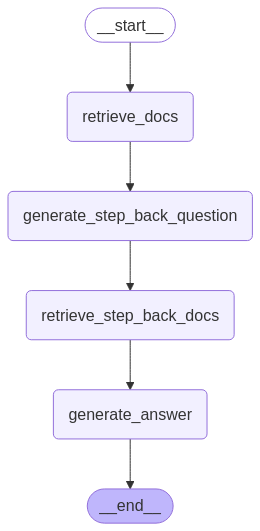

In [20]:
graph_builder = StateGraph(State)

graph_builder.add_node("retrieve_docs", retrieve_docs)
graph_builder.add_node("generate_step_back_question", generate_step_back_question)
graph_builder.add_node("retrieve_step_back_docs", retrieve_step_back_docs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "retrieve_docs")
graph_builder.add_edge("retrieve_docs", "generate_step_back_question")
graph_builder.add_edge("generate_step_back_question", "retrieve_step_back_docs")
graph_builder.add_edge("retrieve_step_back_docs", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()
graph

In [21]:
print(query)

response = graph.invoke({"question": query})

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'context': [Document(...), Document(...), Document(...), Document(...)],
    'step_back_question': 'AI: what is the concept of task decomposition?',
    'step_back_context': [Document(...), Document(...), Document(...), Document(...)],
    'answer': 'Task decomposition for LLM (large language model) agents refers to the process by which an agent 
breaks down a complex task into smaller, more manageable subgoals or steps. This technique is essential for 
efficiently handling complicated tasks that require multiple steps and careful planning.\n\nA prominent method 
utilized for task decomposition is the Chain of Thought (CoT) prompting technique, which encourages the model to 
"think step by step." By allowing the LLM to utilize more computational resources during test time, CoT helps the 
model to effectively decompose challenging tasks into simpler components. This transformation enhances the model\'s
performance by clarifying its reasoning process and making it easier to tackle difficult problems.\n\nAnother 
approach, known as Tree of Thoughts, extends the CoT methodology by exploring multiple reasoning paths at each 
step. It decomposes the overall problem into several thought steps and generates multiple thoughts for each of 
these steps, leading to a tree-like structure of reasoning options. This structure can be searched using techniques
like breadth-first search (BFS) or depth-first search (DFS), with each state evaluated to help determine the best 
solution.\n\nTask decomposition can also be facilitated through various prompts or task-specific instructions. LLMs
may be prompted with simple questions such as “What are the subgoals for achieving XYZ?” or given specific 
instructions like “Write a story outline.” Additionally, human inputs can also guide the decomposition process, 
allowing for an interactive and adaptive approach.\n\nOverall, task decomposition is a crucial capability for LLM 
agents, enabling them to approach complex tasks systematically and improve their overall problem-solving 
abilities.'
}

Task decomposition for LLM (large language model) agents refers to the process by which an agent breaks down a     
complex task into smaller, more manageable subgoals or steps. This technique is essential for efficiently handling 
complicated tasks that require multiple steps and careful planning.                                                

A prominent method utilized for task decomposition is the Chain of Thought (CoT) prompting technique, which        
encourages the model to "think step by step." By allowing the LLM to utilize more computational resources during   
test time, CoT helps the model to effectively decompose challenging tasks into simpler components. This            
transformation enhances the model's performance by clarifying its reasoning process and making it easier to tackle 
difficult problems.                                                                                                

Another approach, known as Tree of Thoughts, extends the CoT methodology by exploring multiple reasoning paths at  
each step. It decomposes the overall problem into several thought steps and generates multiple thoughts for each of
these steps, leading to a tree-like structure of reasoning options. This structure can be searched using techniques
like breadth-first search (BFS) or depth-first search (DFS), with each state evaluated to help determine the best  
solution.                                                                                                          

Task decomposition can also be facilitated through various prompts or task-specific instructions. LLMs may be      
prompted with simple questions such as “What are the subgoals for achieving XYZ?” or given specific instructions   
like “Write a story outline.” Additionally, human inputs can also guide the decomposition process, allowing for an 
interactive and adaptive approach.                                                                                 

Overall, task decomposition is a crucial capability for LLM agents, enabling them to approach complex tasks        
systematically and improve their overall problem-solving abilities.